In [52]:
import pandas as pd
import pickle

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,  make_scorer, precision_score, recall_score, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [20]:
### YOUR PATH HERE
filepath = '.'

# Import the dataset

In [66]:
df = pd.read_csv(filepath + '/data/second_gen/ratings.csv')[1:].fillna('')
df['labels'] = df.apply(lambda x: x['rating_consensus'] if x['rating_consensus'] != '' else x['rating1'] if ((x['rating1'] == x['rating2']) and (x['consensus_reason'] == '') and (x['rating1'] != '')) else 'error', axis=1)
train_val_df = df[:3133]
test_df = df[3133:3133+800]
print('Number of samples in all df: {}, Number of samples in test df: {}, Number of samples in train_val df: {}'.format(len(df),len(test_df), len(train_val_df)))
print('Number of included in train_val: {}'.format(train_val_df['labels'].sum()))
print('Number of included in test: {}'.format(test_df['labels'].sum()))

Number of samples in all df: 5784, Number of samples in test df: 800, Number of samples in train_val df: 3133
Number of included in train_val: 221.0
Number of included in test: 54.0


In [22]:
df_columns_to_keep = ['text', 'labels']
train_val_df = train_val_df[df_columns_to_keep]
test_df = test_df[df_columns_to_keep]

# Helper functions

In [34]:
def grid_search(model_name, search_name, pipe, param, metrics_dict, refit, features, labels):
  grid = GridSearchCV(pipe,param,scoring=metrics_dict, refit=refit, cv=5, verbose=2, n_jobs=-1)
  grid.fit(features,labels)
  results_df = pd.DataFrame.from_dict(grid.cv_results_)
  with open(filepath + '/results/' + model_name + '/' + search_name + '.pkl', mode='wb') as file:
    pickle.dump(results_df, file)
  print('Best parameters: {}'.format(grid.best_params_))
  if refit == True:
    metrics_list = 'mean_test_score'
  else:
    metrics_list = ['mean_test_' + k for k,_ in metrics_dict.items()]
    if len(metrics_list) == 1:
      metrics_list = metrics_list[0]
  print(results_df[metrics_list])
  print('Best index: {}'.format(grid.best_index_))
  return grid, results_df

# Explore possible models to select for review

## First grid search

In [28]:
basic_pipe = Pipeline ([
                  ('feature_ext_1', 'passthrough'),
                  ('feature_ext_2', 'passthrough'),
                  ('classify', 'passthrough')
])

basic_param = [
        {
          'feature_ext_1':[CountVectorizer()],
          'feature_ext_2':[LatentDirichletAllocation()],
          'feature_ext_2__n_components':[32,64,128],
          'classify':[LogisticRegression(), SVC(), RandomForestClassifier(),
                      ExtraTreesClassifier(), AdaBoostClassifier(),
                      KNeighborsClassifier()
                      ]  
        },
        {
          'feature_ext_1':[TfidfVectorizer()],
          'feature_ext_2':[TruncatedSVD()],
          'feature_ext_2__n_components':[32,64,128,256],
          'classify':[LogisticRegression(), SVC(), RandomForestClassifier(),
                      ExtraTreesClassifier(), AdaBoostClassifier(),
                      KNeighborsClassifier()
                      ]  
        },
        {
          'feature_ext_1':[CountVectorizer()],
          'classify':[MultinomialNB()]  
        },
]

basic_grid, basic_grid_df = grid_search('inclusion/sklearn_hp_search', 'basic', basic_pipe, basic_param, {'f1':'f1', 'accuracy':'accuracy', 'recall':'recall', 'precision':'precision'}, 'recall', train_val_df['text'], train_val_df['labels'])

Fitting 5 folds for each of 43 candidates, totalling 215 fits
Best parameters: {'classify': MultinomialNB(), 'feature_ext_1': CountVectorizer()}
    mean_test_f1  mean_test_accuracy  mean_test_recall  mean_test_precision
0       0.170370            0.933293          0.104395             0.589573
1       0.287116            0.939992          0.186598             0.866667
2       0.368260            0.941909          0.246332             0.767965
3       0.379240            0.941586          0.278781             0.703615
4       0.473412            0.939993          0.396516             0.646817
5       0.584298            0.948293          0.522599             0.694167
6       0.289536            0.937120          0.200243             0.627843
7       0.253462            0.934889          0.158772             0.708929
8       0.194166            0.932016          0.115998             0.657143
9       0.303544            0.937120          0.198852             0.703009
10      0.364085   

## Second grid search

In [35]:
mnb_pipe = Pipeline ([
                  ('feature_ext_1', CountVectorizer()),
                  ('classify', MultinomialNB())
])

mnb_param = [
        {
          'classify__alpha':[0.1,0.2,0.5,0.8,1,1.2,1.8,2,5]  
        },
]

mnb_grid, mnb_grid_df = grid_search('inclusion/sklearn_hp_search', 'mnb_finetune', mnb_pipe, mnb_param, {'f1':'f1', 'accuracy':'accuracy', 'recall':'recall', 'precision':'precision'}, 'recall', train_val_df['text'], train_val_df['labels'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'classify__alpha': 0.2}
   mean_test_f1  mean_test_accuracy  mean_test_recall  mean_test_precision
0      0.602244            0.919886          0.859697             0.464993
1      0.582998            0.911906          0.873333             0.439401
2      0.589394            0.915415          0.859697             0.450893
3      0.610072            0.928187          0.791919             0.499131
4      0.611603            0.934248          0.737374             0.526751
5      0.620027            0.941909          0.678485             0.574242
6      0.503122            0.942226          0.416162             0.639582
7      0.450911            0.940949          0.348182             0.647980
8      0.008696            0.929142          0.004545             0.100000
Best index: 1


## Evaluate tuned pipeline

In [45]:
final_pipe = Pipeline ([
                  ('feature_ext_1', CountVectorizer()),
                  ('classify', MultinomialNB(alpha=0.2))
])
final_pipe.fit(train_val_df['text'], train_val_df['labels'])

Pipeline(steps=[('feature_ext_1', CountVectorizer()),
                ('classify', MultinomialNB(alpha=0.2))])

In [56]:
preds = final_pipe.predict(test_df['text'])
recall = recall_score(test_df['labels'], preds)
precision = precision_score(test_df['labels'], preds)
print('Precision: {:.3f}  , Recall: {:.3f}'.format(precision,recall))

Precision: 0.406  , Recall: 0.796


## Determine threshold to maximize recall

In [51]:
all_df = df[:3133+800][df_columns_to_keep]
len(all_df)

3933

                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
2  Leveraging the pharmacy executive beyond the p...     0.0
3  The utilization of simulated patients for teac...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
                                                 text  labels
11  A multifaceted approach in leveraging electron...     0.0
22  Oxcarbazepine-Induced Cutaneous Reaction in a ...     0.0
25  Searching the Literature: A Simple Step-Wise P...     0.0
37  Roles of Pharmacy Technicians in Preventing Pr...     0.0
38  Evaluation of Patient Factors Associated With ...     0.0
                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
2  Leveraging the pharmacy executive beyond the p...     0.0
3  The utilization of simulated patients for teac...     0.0
4  Implementing an

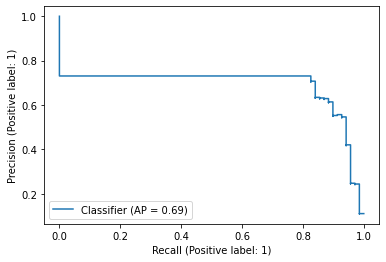

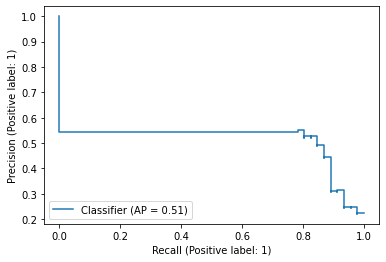

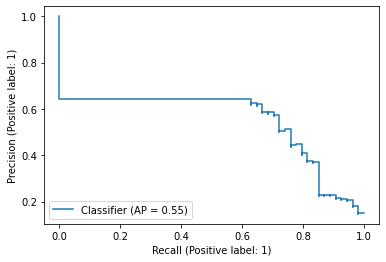

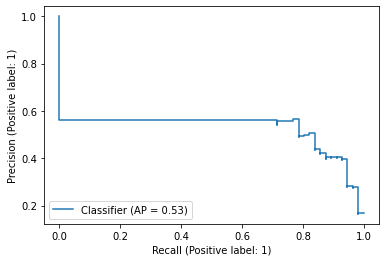

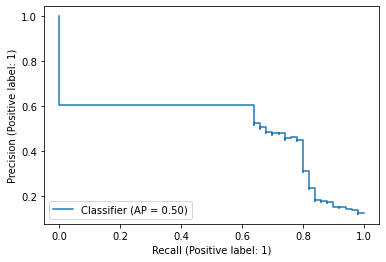

In [62]:
kf = KFold(n_splits=5, shuffle=True)
thresholds = []


for train_idx, val_idx in kf.split(all_df):
    train = all_df.iloc[train_idx]
    print(train.head())
    val = all_df.iloc[val_idx]
    print(val.head())
    
    fold_pipe = Pipeline ([
                  ('feature_ext_1', CountVectorizer()),
                  ('classify', MultinomialNB(alpha=0.2))
    ])
    fold_pipe.fit(train['text'], train['labels'])
    scores = fold_pipe.predict_proba(val['text'])[:,1]

    PrecisionRecallDisplay.from_predictions(val['labels'], scores)

    pr,re,th = precision_recall_curve(val['labels'], scores)
    rth_df = pd.DataFrame.from_dict({'precision':pr[:-1],'recall':re[:-1],'threshold':th})

    ceiling_recall = 0.99
    thresholds.append(rth_df[rth_df.recall >= ceiling_recall].iloc[-1]['threshold'])

In [63]:
thr_df = pd.DataFrame(thresholds)
thr_df

,0
0,4.790254e-66
1,5.881673e-09
2,1.422739e-34
3,8.517278e-32
4,1.333260e-43


In [64]:
threshold = thr_df.mean()[0]
print('Mean threshold: {:.20f}'.format(threshold))
recall_test = []
preds = []
incorrect = []
for i, label, score in zip(range(len(val['labels'])), val['labels'], scores):
    if score >= threshold:
        recall_test.append({'index':i, 'label':label, 'score':score})
        preds.append(1)
    else:
        if label == 1:
            incorrect.append(i)
        preds.append(0)
print('Number of abstracts excluded from review based on recall threshold: {} out of {} for ratio of {:.3f}'.format(len(val) - len(recall_test), len(val), (len(val) - len(recall_test)) / len(val)))
print('Adjusted threshold precision: {:.3f}, recall: {:.3f}, f1: {:.3f}, accuracy: {:.3f}'.format(precision_score(val['labels'], preds), recall_score(val['labels'], preds), f1_score(val['labels'], preds), accuracy_score(val['labels'], preds)))
print('Number of incorrectly excluded abstracts: {}'.format(len(incorrect)))


Mean threshold: 0.00000000117633463522
Number of abstracts excluded from review based on recall threshold: 581 out of 786 for ratio of 0.739
Adjusted threshold precision: 0.205, recall: 0.840, f1: 0.329, accuracy: 0.782
Number of incorrectly excluded abstracts: 8
